# ONNX Runtime推理预测-单张图像

同济子豪兄 2023-5-11

## 导入工具包

In [1]:
import cv2
import numpy as np
from PIL import Image

import onnxruntime

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
kpts_shape = [3, 3] # 关键点 shape

## 创建ONNX Runtime的InferenceSession

In [3]:
ort_session = onnxruntime.InferenceSession('checkpoint/Triangle_215_yolov8l_pretrain.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:56: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  "Available providers: '{}'".format(name, ", ".join(available_provider_names))


## 输入一个随机Tensor，推理预测

In [4]:
import torch
x = torch.randn(1, 3, 640, 640).numpy()

In [5]:
x.shape

(1, 3, 640, 640)

In [6]:
ort_inputs = {'images': x}
ort_output = ort_session.run(['output0'], ort_inputs)[0]

In [7]:
ort_output.shape

(1, 14, 8400)

## 获得ONNX模型输入层和数据维度

In [8]:
model_input = ort_session.get_inputs()
input_name = [model_input[0].name]

In [9]:
input_name

['images']

In [10]:
input_shape = model_input[0].shape

In [11]:
input_shape

[1, 3, 640, 640]

In [12]:
input_height, input_width = input_shape[2:]

## 获得ONNX模型输出层和数据维度

In [13]:
model_output = ort_session.get_outputs()
output_name = [model_output[0].name]

In [14]:
output_name

['output0']

In [15]:
output_shape = model_output[0].shape

In [16]:
output_shape

[1, 14, 8400]

## 载入图像

In [17]:
img_path = 'images/Triangle_4.jpg'

In [18]:
# 导入 BGR 格式的图像
img_bgr = cv2.imread(img_path)

In [19]:
# 获取原图尺寸
img_bgr.shape

(3712, 5568, 3)

In [77]:
## BGR 转 RGB
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(img_rgb)
# plt.show()

## 预处理-缩放图像尺寸

In [20]:
# 预处理-缩放图像尺寸
img_bgr_640 = cv2.resize(img_bgr, [input_height, input_width])

In [21]:
img_bgr_640.shape

(640, 640, 3)

In [22]:
img_rgb_640 = img_bgr_640[:,:,::-1]

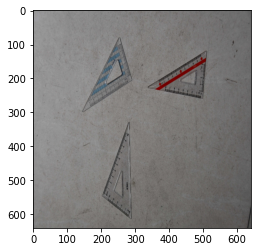

In [23]:
plt.imshow(img_rgb_640)
plt.show()

In [24]:
# X 方向 图像缩放比例
x_ratio = img_bgr.shape[1] / input_width

In [25]:
x_ratio

8.7

In [26]:
# Y 方向 图像缩放比例
y_ratio = img_bgr.shape[0] / input_height

In [27]:
y_ratio

5.8

## 预处理-构造输入张量

In [28]:
# 预处理-归一化
input_tensor = img_rgb_640 / 255

# 预处理-构造输入 Tensor
input_tensor = np.expand_dims(input_tensor, axis=0) # 加 batch 维度
input_tensor = input_tensor.transpose((0, 3, 1, 2)) # N, C, H, W
input_tensor = np.ascontiguousarray(input_tensor)   # 将内存不连续存储的数组，转换为内存连续存储的数组，使得内存访问速度更快
input_tensor = torch.from_numpy(input_tensor).to(device).float() # 转 Pytorch Tensor
# input_tensor = input_tensor.half() # 是否开启半精度，即 uint8 转 fp16，默认转 fp32 

In [29]:
input_tensor.shape

torch.Size([1, 3, 640, 640])

## 执行推理预测

In [30]:
# ONNX Runtime 推理预测
ort_output = ort_session.run(output_name, {input_name[0]: input_tensor.numpy()})[0]

# 转 Tensor
preds = torch.Tensor(ort_output)

In [31]:
preds.shape

torch.Size([1, 14, 8400])

## 后处理-置信度过滤、NMS过滤

In [32]:
from ultralytics.yolo.utils import ops

In [33]:
preds = ops.non_max_suppression(preds, conf_thres=0.25, iou_thres=0.7, nc=1)

In [34]:
pred = preds[0]

In [35]:
pred.shape

torch.Size([3, 15])

In [36]:
pred

tensor([[3.3356e+02, 1.1433e+02, 5.1084e+02, 2.6491e+02, 9.6444e-01, 0.0000e+00, 3.4874e+02, 2.1876e+02, 5.8326e-01, 5.0719e+02, 1.2415e+02, 6.7839e-02, 5.0356e+02, 2.6262e+02, 8.4644e-01],
        [1.4118e+02, 7.6937e+01, 2.9458e+02, 3.0108e+02, 9.6182e-01, 0.0000e+00, 1.4660e+02, 2.8664e+02, 9.5061e-01, 2.2365e+02, 1.0206e+02, 5.6752e-02, 2.9774e+02, 2.0286e+02, 5.8402e-01],
        [1.9991e+02, 3.2783e+02, 2.9268e+02, 6.1581e+02, 9.2235e-01, 0.0000e+00, 2.8595e+02, 3.4267e+02, 1.3498e-02, 2.7482e+02, 6.0522e+02, 9.8041e-01, 2.0725e+02, 5.4902e+02, 8.9631e-01]])

## 解析目标检测预测结果

In [37]:
pred_det = pred[:, :6].cpu().numpy()

In [38]:
# 目标检测预测结果：左上角X、左上角Y、右下角X、右下角Y、置信度、类别ID
pred_det

array([[     333.56,      114.33,      510.84,      264.91,     0.96444,           0],
       [     141.18,      76.937,      294.58,      301.08,     0.96182,           0],
       [     199.91,      327.83,      292.68,      615.81,     0.92235,           0]], dtype=float32)

In [39]:
num_bbox = len(pred_det)
print('预测出 {} 个框'.format(num_bbox))

预测出 3 个框


In [40]:
# 类别
bboxes_cls = pred_det[:, 5]

In [41]:
bboxes_cls

array([          0,           0,           0], dtype=float32)

In [42]:
# 置信度
bboxes_conf = pred_det[:, 4]

In [43]:
bboxes_conf

array([    0.96444,     0.96182,     0.92235], dtype=float32)

In [44]:
pred_det

array([[     333.56,      114.33,      510.84,      264.91,     0.96444,           0],
       [     141.18,      76.937,      294.58,      301.08,     0.96182,           0],
       [     199.91,      327.83,      292.68,      615.81,     0.92235,           0]], dtype=float32)

In [45]:
# 目标检测框 XYXY 坐标
# 还原为缩放之前原图上的坐标
pred_det[:, 0] = pred_det[:, 0] * x_ratio
pred_det[:, 1] = pred_det[:, 1] * y_ratio
pred_det[:, 2] = pred_det[:, 2] * x_ratio
pred_det[:, 3] = pred_det[:, 3] * y_ratio
bboxes_xyxy = pred_det[:, :4].astype('uint32')

In [46]:
bboxes_xyxy

array([[2902,  663, 4444, 1536],
       [1228,  446, 2562, 1746],
       [1739, 1901, 2546, 3571]], dtype=uint32)

## 解析关键点检测预测结果

In [47]:
pred_kpts = pred[:, 6:].view(len(pred), kpts_shape[0], kpts_shape[1])

In [49]:
pred_kpts.shape

torch.Size([3, 3, 3])

In [50]:
bboxes_keypoints = pred_kpts.cpu().numpy()

In [51]:
bboxes_keypoints

array([[[     348.74,      218.76,     0.58326],
        [     507.19,      124.15,    0.067839],
        [     503.56,      262.62,     0.84644]],

       [[      146.6,      286.64,     0.95061],
        [     223.65,      102.06,    0.056752],
        [     297.74,      202.86,     0.58402]],

       [[     285.95,      342.67,    0.013498],
        [     274.82,      605.22,     0.98041],
        [     207.25,      549.02,     0.89631]]], dtype=float32)

In [52]:
# 还原为缩放之前原图上的坐标
bboxes_keypoints[:,:,0] = bboxes_keypoints[:,:,0] * x_ratio
bboxes_keypoints[:,:,1] = bboxes_keypoints[:,:,1] * y_ratio
bboxes_keypoints = bboxes_keypoints.astype('uint32')

In [53]:
bboxes_keypoints

array([[[3034, 1268,    0],
        [4412,  720,    0],
        [4380, 1523,    0]],

       [[1275, 1662,    0],
        [1945,  591,    0],
        [2590, 1176,    0]],

       [[2487, 1987,    0],
        [2390, 3510,    0],
        [1803, 3184,    0]]], dtype=uint32)

## OpenCV可视化关键点

In [54]:
# 框（rectangle）可视化配置
bbox_color = (150, 0, 0)             # 框的 BGR 颜色
bbox_thickness = 6                   # 框的线宽

# 框类别文字
bbox_labelstr = {
    'font_size':4,         # 字体大小
    'font_thickness':10,   # 字体粗细
    'offset_x':0,          # X 方向，文字偏移距离，向右为正
    'offset_y':-80,        # Y 方向，文字偏移距离，向下为正
}

In [55]:
# 关键点 BGR 配色
kpt_color_map = {
    0:{'name':'angle_30', 'color':[255, 0, 0], 'radius':40},      # 30度角点
    1:{'name':'angle_60', 'color':[0, 255, 0], 'radius':40},      # 60度角点
    2:{'name':'angle_90', 'color':[0, 0, 255], 'radius':40},      # 90度角点
}

# 点类别文字
kpt_labelstr = {
    'font_size':4,             # 字体大小
    'font_thickness':10,       # 字体粗细
    'offset_x':30,             # X 方向，文字偏移距离，向右为正
    'offset_y':120,            # Y 方向，文字偏移距离，向下为正
}

# 骨架连接 BGR 配色
skeleton_map = [
    {'srt_kpt_id':0, 'dst_kpt_id':1, 'color':[196, 75, 255], 'thickness':3},        # 30度角点-60度角点
    {'srt_kpt_id':0, 'dst_kpt_id':2, 'color':[180, 187, 28], 'thickness':3},        # 30度角点-90度角点
    {'srt_kpt_id':1, 'dst_kpt_id':2, 'color':[47,255, 173], 'thickness':3},         # 60度角点-90度角点
]

In [56]:
for idx in range(num_bbox): # 遍历每个框
    
    # 获取该框坐标
    bbox_xyxy = bboxes_xyxy[idx] 
    
    # 获取框的预测类别（对于关键点检测，只有一个类别）
    bbox_label = 'sjb_rect'
    
    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), bbox_color, bbox_thickness)
    
    # 写框类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
    img_bgr = cv2.putText(img_bgr, bbox_label, (bbox_xyxy[0]+bbox_labelstr['offset_x'], bbox_xyxy[1]+bbox_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, bbox_labelstr['font_size'], bbox_color, bbox_labelstr['font_thickness'])
    
    bbox_keypoints = bboxes_keypoints[idx] # 该框所有关键点坐标和置信度
    
    # 画该框的骨架连接
    for skeleton in skeleton_map:
        
        # 获取起始点坐标
        srt_kpt_id = skeleton['srt_kpt_id']
        srt_kpt_x = bbox_keypoints[srt_kpt_id][0]
        srt_kpt_y = bbox_keypoints[srt_kpt_id][1]
        
        # 获取终止点坐标
        dst_kpt_id = skeleton['dst_kpt_id']
        dst_kpt_x = bbox_keypoints[dst_kpt_id][0]
        dst_kpt_y = bbox_keypoints[dst_kpt_id][1]
        
        # 获取骨架连接颜色
        skeleton_color = skeleton['color']
        
        # 获取骨架连接线宽
        skeleton_thickness = skeleton['thickness']
        
        # 画骨架连接
        img_bgr = cv2.line(img_bgr, (srt_kpt_x, srt_kpt_y),(dst_kpt_x, dst_kpt_y),color=skeleton_color,thickness=skeleton_thickness)
        
    # 画该框的关键点
    for kpt_id in kpt_color_map:
        
        # 获取该关键点的颜色、半径、XY坐标
        kpt_color = kpt_color_map[kpt_id]['color']
        kpt_radius = kpt_color_map[kpt_id]['radius']
        kpt_x = bbox_keypoints[kpt_id][0]
        kpt_y = bbox_keypoints[kpt_id][1]
        
        # 画圆：图片、XY坐标、半径、颜色、线宽（-1为填充）
        img_bgr = cv2.circle(img_bgr, (kpt_x, kpt_y), kpt_radius, kpt_color, -1)
        
        # 写关键点类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
        # kpt_label = str(kpt_id) # 写关键点类别 ID
        kpt_label = str(kpt_color_map[kpt_id]['name']) # 写关键点类别名称
        img_bgr = cv2.putText(img_bgr, kpt_label, (kpt_x+kpt_labelstr['offset_x'], kpt_y+kpt_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, kpt_labelstr['font_size'], kpt_color, kpt_labelstr['font_thickness'])

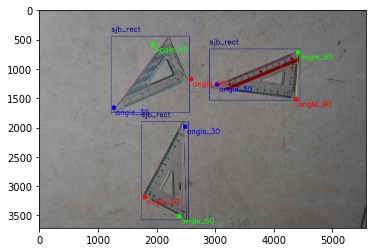

In [57]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()